
# Introduction to plotting NARCliM2.0 tasmax over Western Australia

This notebook demonstrates how to:

- Access NARCliM2.0 monthly `tasmax` (daily maximum near-surface air temperature) data.
- Inspect the dataset structure (time, rlat, rlon, lat, lon).
- Subset the data to Western Australia using a latitude–longitude box.
- Plot a single timestep and multiple timesteps in Kelvin.
- Customise colour maps and value ranges for climate visualisation.



## 1. Load packages


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature


## 2. Define data source and load NARCliM2.0 tasmax


In [2]:
url = (
    "https://dapds00.nci.org.au/thredds/dodsC/zz63/NARCliM2-0/output-CMIP6/DD/AUS-18/NSW-Government/ACCESS-ESM1-5/ssp126/r6i1p1f1/NARCliM2-0-WRF412R3/v1-r1/mon/tasmax/latest/tasmax_AUS-18_ACCESS-ESM1-5_ssp126_r6i1p1f1_NSW-Government_NARCliM2-0-WRF412R3_v1-r1_mon_201501-201512.nc"
)

ds = xr.open_dataset(url)

## 3. Inspect dataset and variable metadata


In [3]:
# Overview of dimensions, coordinates and variables
print(ds)

# Focus on tasmax attributes
print("tasmax attributes:")
for k, v in ds.tasmax.attrs.items():
    print(f"  {k}: {v}")

# Check coordinate ranges
print("lon range:", float(ds.lon.min()), "to", float(ds.lon.max()))
print("lat range:", float(ds.lat.min()), "to", float(ds.lat.max()))


<xarray.Dataset> Size: 10MB
Dimensions:    (time: 12, rlat: 321, rlon: 497, bnds: 2, crs: 1)
Coordinates:
  * time       (time) datetime64[ns] 96B 2015-01-16T12:00:00 ... 2015-12-16T1...
  * rlat       (rlat) float64 3kB -22.88 -22.71 -22.53 ... 33.08 33.26 33.44
  * rlon       (rlon) float64 4kB -178.5 -178.3 -178.2 ... 178.2 178.3 178.5
  * crs        (crs) int32 4B 2143289344
    time_bnds  (time, bnds) datetime64[ns] 192B ...
    height     float64 8B ...
    lat        (rlat, rlon) float64 1MB ...
    lon        (rlat, rlon) float64 1MB ...
Dimensions without coordinates: bnds
Data variables:
    tasmax     (time, rlat, rlon) float32 8MB ...
Attributes: (12/43)
    project_id:                      CORDEX
    comment:                         DPIE version of WRF4.1.2
    DPIE_WRF_HASH:                   a051fdc73749349fd244ce8e596088a372bdb0c5
    wrf_options:                     sst_update & tmn_update
    frequency:                       mon
    git_url_postprocessing:          gi

## 4. Define Western Australia analysis region


In [4]:
# Approximate Western Australia geographic bounding box (Plate Carree coordinates)
wa_lon_min, wa_lon_max = 112.0, 130.0
wa_lat_min, wa_lat_max = -36.0, -13.0

lat = ds["lat"]
lon = ds["lon"]

# Mask points outside WA box
wa_mask = (
    (lon >= wa_lon_min) & (lon <= wa_lon_max) &
    (lat >= wa_lat_min) & (lat <= wa_lat_max)
)

# Apply WA mask to tasmax for all timesteps (still in Kelvin)
tasmax_wa = ds.tasmax.where(wa_mask)


## 5. Plot single timestep over WA (Kelvin)


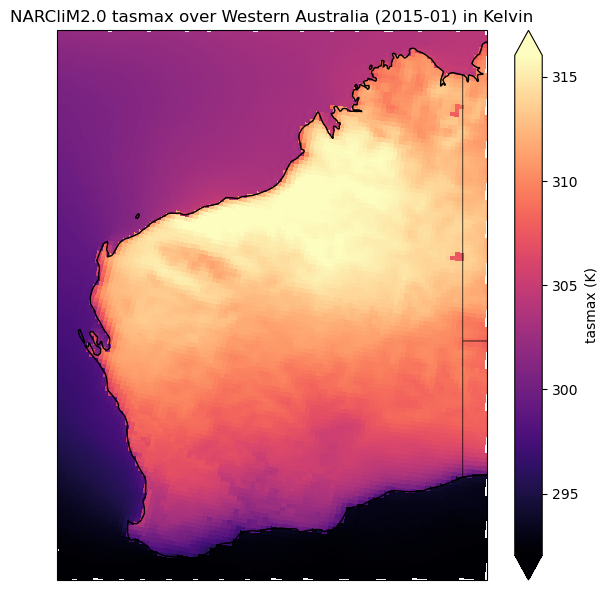

In [5]:
# Select first timestep (January 2015)
t_index = 0
tasmax_wa_single = tasmax_wa.isel(time=t_index)

plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Zoom to WA region
ax.set_extent([wa_lon_min, wa_lon_max, wa_lat_min, wa_lat_max],
              crs=ccrs.PlateCarree())

# Add map features
ax.coastlines(resolution="50m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.3)

# Plot tasmax in Kelvin using 2-D lat/lon
im = tasmax_wa_single.plot(
    ax=ax,
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    cmap="magma",
    robust=True,
    cbar_kwargs={"label": "tasmax (K)"}
)

time_str = str(tasmax_wa_single["time"].dt.strftime("%Y-%m").values)
ax.set_title(f"NARCliM2.0 tasmax over Western Australia ({time_str}) in Kelvin")

plt.tight_layout()


## 6. Plot multiple timesteps (faceted) over WA


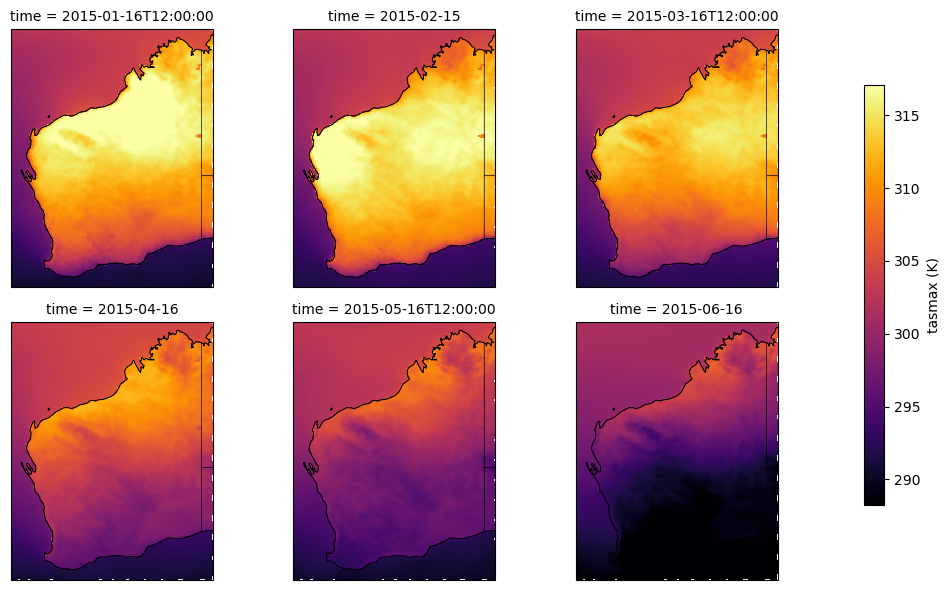

In [6]:
# Select first six months of 2015
tasmax_wa_6 = tasmax_wa.isel(time=slice(0, 6))
g = tasmax_wa_6.plot(
    col="time",
    col_wrap=3,
    x="lon",
    y="lat",
    cmap="inferno",
    robust=True,
    subplot_kws={"projection": ccrs.PlateCarree()},
    add_colorbar=False   # 👈 turn off auto colorbar
)

# --- add one shared colorbar on the side ---
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

fig = g.fig
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]

sm = ScalarMappable(cmap="inferno")
sm.set_array(tasmax_wa_6.values)

cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("tasmax (K)")

# --- map features ---
for ax in g.axes.flat:
    if ax is None:
        continue
    ax.set_extent([wa_lon_min, wa_lon_max, wa_lat_min, wa_lat_max],
                  crs=ccrs.PlateCarree())
    ax.coastlines(resolution="50m", linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.STATES, linewidth=0.3)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar
plt.show()


## 7. Custom colour stretch in Kelvin


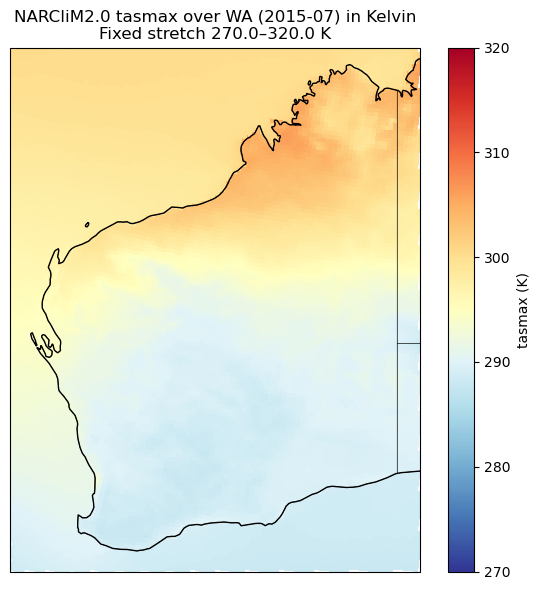

In [7]:
# Choose a mid-year month, e.g. July 2015
t_index = 6
tasmax_wa_july = tasmax_wa.isel(time=t_index)

# Set a fixed Kelvin range for consistent comparison
vmin_k = 270.0
vmax_k = 320.0

plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([wa_lon_min, wa_lon_max, wa_lat_min, wa_lat_max],
              crs=ccrs.PlateCarree())

ax.coastlines(resolution="50m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.3)

tasmax_wa_july.plot(
    ax=ax,
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=vmin_k,
    vmax=vmax_k,
    cmap="RdYlBu_r",
    cbar_kwargs={"label": "tasmax (K)"}
)

time_str = str(tasmax_wa_july["time"].dt.strftime("%Y-%m").values)
ax.set_title(f"NARCliM2.0 tasmax over WA ({time_str}) in Kelvin\nFixed stretch {vmin_k}–{vmax_k} K")

plt.tight_layout()


## 8. Time series at a single WA location 


Nearest grid point: rlat=98, rlon=84
lat=-32.022350084853606, lon=115.95722673838013


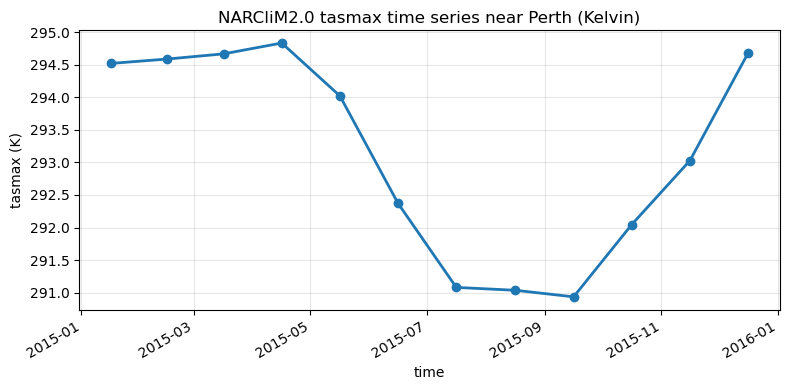

In [51]:
# Pick a location near Perth
target_lon = 116.0
target_lat = -32.0

# Find nearest grid indices using rlat/rlon (the actual dimensions)
# Average lat across rlon to get lat profile of each rlat
lat_profile = ds.lat.mean(dim='rlon')
rlat_idx = (abs(lat_profile - target_lat)).argmin(dim='rlat')

# Average lon across rlat to get lon profile of each rlon  
lon_profile = ds.lon.mean(dim='rlat')
rlon_idx = (abs(lon_profile - target_lon)).argmin(dim='rlon')

print(f"Nearest grid point: rlat={rlat_idx.values}, rlon={rlon_idx.values}")
print(f"lat={float(lat_profile.isel(rlat=rlat_idx))}, lon={float(lon_profile.isel(rlon=rlon_idx))}")

# Extract time series from WA subset using these indices
tasmax_point_wa = tasmax_wa.isel(rlat=rlat_idx, rlon=rlon_idx).squeeze()

# Plot the time series (in Kelvin)
ts = tasmax_point_wa.to_series().dropna()
plt.figure(figsize=(8, 4))
ts.plot(marker="o", linewidth=2, markersize=6)
plt.ylabel("tasmax (K)")
plt.title("NARCliM2.0 tasmax time series near Perth (Kelvin)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [26]:
print(ds.lon.min().item(), ds.lon.max().item())
print(ds.lat.min().item(), ds.lat.max().item())


-179.99978637695312 179.99977111816406
-52.57440185546875 12.093093872070312


## Recommended next steps

- Change the Western Australia bounding box to focus on specific regions (e.g. Kimberley, Pilbara).
- Repeat the plots for other variables (e.g. `tasmin`, `pr`).
- Compare different NARCliM experiments (e.g. `ssp126` vs `ssp370`).
- Aggregate to seasonal or annual means using `ds.tasmax.groupby("time.season").mean("time")`.
